Check the bottom for my Bayes classifier.
=====

### "Working with Text Data" Tutorial



In [2]:
%matplotlib inline
import numpy as np
import random
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

from math import log, sqrt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [3]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

x_train_counts = count_vect.fit_transform(twenty_train.data)

count_vect.vocabulary_.get('algorithm')

4690

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(x_train_counts)

x_train_tf = tf_transformer.transform(x_train_counts)

x_train_tf.shape

(2257, 35788)

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

x_train_tfidf.shape

(2257, 35788)

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(x_train_tfidf, twenty_train.target)

docs_new = ['God is love', 'OpenGL on the GPU is fast', ]
x_new_counts = count_vect.transform(docs_new)
x_new_tfidf = tfidf_transformer.transform(x_new_counts)

predicted = clf.predict(x_new_tfidf)

print(twenty_train.target_names)
print(clf.predict_proba(x_new_tfidf))

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, twenty_train.target_names[category]))

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
[[ 0.16297502  0.03828016  0.03737814  0.76136668]
 [ 0.16387956  0.36874738  0.2364763   0.23089675]]
'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


In [8]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

text_clf

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [9]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

docs_test = twenty_test.data

predicted = text_clf.predict(docs_test)

np.mean(predicted == twenty_test.target)

0.83488681757656458

In [10]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42))])

text_clf.fit(twenty_train.data, twenty_train.target)

predicted = text_clf.predict(docs_test)

np.mean(predicted == twenty_test.target)

0.9127829560585885

                        precision    recall  f1-score   support

           alt.atheism       0.95      0.81      0.87       319
         comp.graphics       0.88      0.97      0.92       389
               sci.med       0.94      0.90      0.92       396
soc.religion.christian       0.90      0.95      0.93       398

           avg / total       0.92      0.91      0.91      1502



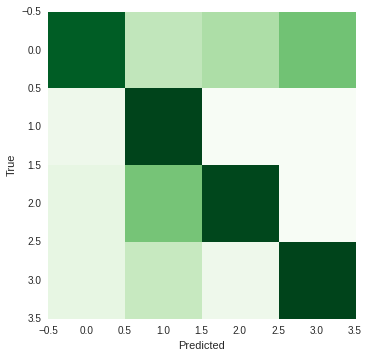

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(twenty_test.target, predicted, target_names=twenty_test.target_names))

plt.imshow(np.log(confusion_matrix(twenty_test.target, predicted)), cmap = 'Greens', interpolation = 'nearest')
plt.grid(False)
plt.ylabel('True')
plt.xlabel('Predicted')

### Choosing the best parameters

In [12]:
from sklearn.grid_search import GridSearchCV

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3)
             }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(twenty_train.data[:400], twenty_train.target[:400])

twenty_train.target_names[gs_clf.predict(['God is love'])]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


'soc.religion.christian'

In [13]:
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
    
score

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


0.90000000000000002

Implementing a Bayes Classifier
===

### Bayes Theorem

P(A|B) = P(A) * P(B|A) / P(B)

P(S|W) = [P(W|S) * P(S)] / [P(W|S) * P(S) + P(W|H) * P(H)]
If P(S) = P(H), then P(S|W) = P(W|S) / [P(W|S) + P(W|H)]

### Recognizing a word.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

docs = fetch_20newsgroups(shuffle=True, random_state=42)

train, test, train_target, test_target = train_test_split(docs.data, docs.target)

vect = TfidfVectorizer(use_idf = False, stop_words = ENGLISH_STOP_WORDS)
tf = vect.fit_transform(train)
wordList = vect.get_feature_names()

# Number of documents in each category
cat_counts = {}
for idx, target in enumerate(train_target):
    if target in cat_counts:
        cat_counts[target].append(idx)
    else:
        cat_counts[target] = [idx]

# Probability that a word belongs to the given category
def cat_prob(cat_idx, word):
    instances = 0
    for doc in cat_counts[cat_idx]:
        try: # Just in case the word is not found
            if tf[doc, wordList.index(word)] > 0:
                instances += 1
        except:
            pass
    try: # Just in case division by zero happens.
        return instances / len(cat_counts[cat_idx])
    except:
        return None
    
# Probable category of a message with the given word
def word_prob(word):
    divisor = 0
    possible = []
    for name in docs.target_names:
        pC = len(cat_counts[docs.target_names.index(name)]) / len(train_target)
        pWC = cat_prob(docs.target_names.index(name), word)
        divisor += pWC
        possible.append(pWC * pC)
    possible = [x / divisor for x in possible]
    return possible
    
# Given a dictionary of probabilities
def get_cat(probs):
    return docs.target_names[probs.index(max(probs))]

In [15]:
get_cat(word_prob("windows"))

'comp.os.ms-windows.misc'

In [16]:
get_cat(word_prob("god"))

'soc.religion.christian'

In [17]:
get_cat(word_prob("car"))

'rec.autos'

In [18]:
get_cat(word_prob("jim"))

'talk.politics.guns'

### Recognizing a collection of words.

In [19]:
# This function fixes the text so that it is more easily readable by the computer
def fix_text(text):
    ALPHANUMERIC = "a b c d e f g h i j k l m n o p q r s t u v w x y z 0 1 2 3 4 5 6 7 8 9".split(' ')
    new_text = ""
    for char in text.lower():
        if char in ALPHANUMERIC:
            new_text += char
        else:
            new_text += ' '
    return [x for x in new_text.split() if not x.isdigit() and not x in ENGLISH_STOP_WORDS]

# This function turns zero values into ones
def oneify(num):
    if num == 0:
        return 1
    else:
        return num

# This function categorizes a list of words
def list_cat(words):
    probs = []
    for word in words:
        probs.append(word_prob(word))
    final = []
    for idx, target in enumerate(docs.target_names):
        product = np.prod([x[idx] for x in probs])
        sub_prod = np.prod([(1 - x[idx]) for x in probs])
        final.append(product / (product + sub_prod))
    return final

In [20]:
get_cat(list_cat(fix_text("Windows is software, not hardware.")))

'comp.os.ms-windows.misc'

In [21]:
get_cat(list_cat(fix_text("God is good.")))

'soc.religion.christian'

In [22]:
get_cat(list_cat(fix_text("Jim drove his big muscle car to the gun festival.")))

'alt.atheism'

Some notes about this algorithm:
- Individual word checking seems to be fairly reliable. Sentence checking less so.
- Any item the algorithm cannot classify is attributed to alt.atheism (because alt.atheism is first in the target list).
- The classifier takes too long to run to make checking anything in large volumes realistic.